In [1]:
#%% Imports
import os
import zipfile
import shutil
import urllib

import rioxarray
import xarray as xr
import numpy as np
import rasterio
import cdsapi


In [2]:
#%% Definitions

# Somalia
lat = [-2, 12]
lon = [40, 52]
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
# years = range(2010, 2012+1)
# Variables of interest
era5_vars = ['2m_temperature', 'potential_evaporation',
             'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2',
             'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4']

months = ['%02d' % x for x in range(1, 12+1)]
days = ['%02d' % x for x in range(1, 31+1)]

# Downloaded products won't have projection (or they have lost it)
# We have to manually (re)set it.
crs_projection = 'epsg:4326'


In [3]:

#%% Download ERA5 datasets
"""
Go to https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.e2161bac?tab=form
and accept the license terms.
"""
def download_era5(year):
    era5_fname = 'era5_%d.nc' % year
    if os.path.exists(era5_fname):
        print("  %s already downloaded, skipping" % era5_fname)
        return

    fname = 'download_%d.zip' % year
    print("Download", fname, "...")
    if os.path.exists(fname):
        print("  %s already downloaded" % fname)
    else:
        c = cdsapi.Client()
        c.retrieve(
            'reanalysis-era5-land',
            {
                'variable': era5_vars,
                'year': year,
                'month': months,
                'day': days,
                'time': ['00:00', '12:00'],
                'area': [lat[1], lon[0], lat[0], lon[1]],
                'format': 'netcdf.zip'
            },
            fname
        )
        print("  done")
    # Uncompress
    with zipfile.ZipFile(fname) as zf:
        zf.extractall()
    # Rename
    os.rename('data.nc', era5_fname)
    # Delete downloaded zip
    os.unlink(fname)


for year in years:
    download_era5(year)



#%% Download CHIRPS
def download_chirps(year):
    base_url = 'https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/'
    base_fname = 'chirps-v2.0.%d.days_p05.nc' % year

    print("Download", base_fname, "...")
    if os.path.exists(base_fname):
        print("  %s file already exists" % base_fname)
    else:
        with urllib.request.urlopen(base_url + base_fname) as response:
            with open(base_fname, 'wb') as file:
                shutil.copyfileobj(response, file)
        print("  done")


for year in years:
    download_chirps(year)



#%% Download land cover
# These files are also quite big, store in erc/databases or remove them after interpolation
"""
Go to https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-land-cover?tab=form
and accept the license terms.
"""
def download_landcover(year):
    fname = 'download_lc_copernicus_%d.zip' % year
    print("Download", fname, "...")
    if os.path.exists(fname):
        print("  already exists, skipping")
    else:
        c = cdsapi.Client()

        if year < 2016:
            c.retrieve(
                'satellite-land-cover',
                {
                    'variable': 'all',
                    'format': 'zip',
                    'year': year,
                    'version': 'v2.0.7cds',
                },
                fname
            )
            print("  done")

        if year >= 2016:
            c.retrieve(
            'satellite-land-cover',
            {
                'variable': 'all',
                'format': 'zip',
                'year': year,
                'version': 'v2.1.1',
            },
            fname
        )
        print("  done")

        # Extract
        with zipfile.ZipFile(fname) as zf:
            lc_fname = zf.namelist()[0]
            if not os.path.exists(lc_fname):
                zf.extractall()

        # print("  removing downloaded file ...")
        # os.unlink(fname)

        return lc_fname


years_lc = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023] 

full_lc_fnames = []
for year in years_lc:
    if year < 2021:
        full_lc_fnames.append(download_landcover(year))
# full_lc_fnames = ['ESACCI-LC-L4-LCCS-Map-300m-P1Y-2010-v2.0.7cds.nc']


  era5_2000.nc already downloaded, skipping
  era5_2001.nc already downloaded, skipping
  era5_2002.nc already downloaded, skipping
  era5_2003.nc already downloaded, skipping
  era5_2004.nc already downloaded, skipping
  era5_2005.nc already downloaded, skipping
  era5_2006.nc already downloaded, skipping
  era5_2007.nc already downloaded, skipping
  era5_2008.nc already downloaded, skipping
  era5_2009.nc already downloaded, skipping
  era5_2010.nc already downloaded, skipping
  era5_2011.nc already downloaded, skipping
  era5_2012.nc already downloaded, skipping
  era5_2013.nc already downloaded, skipping
  era5_2014.nc already downloaded, skipping
  era5_2015.nc already downloaded, skipping
  era5_2016.nc already downloaded, skipping
  era5_2017.nc already downloaded, skipping
  era5_2018.nc already downloaded, skipping
  era5_2019.nc already downloaded, skipping
  era5_2020.nc already downloaded, skipping
  era5_2021.nc already downloaded, skipping
  era5_2022.nc already downloade

In [4]:

#%% Read and concatenate datasets
def crop_ds(ds):
    lat_name = 'lat' if 'lat' in ds.keys() else 'latitude'
    lon_name = 'lon' if 'lon' in ds.keys() else 'longitude'
    mask_lon = (ds[lon_name] >= lon[0]) & (ds[lon_name] <= lon[1])
    mask_lat = (ds[lat_name] >= lat[0]) & (ds[lat_name] <= lat[1])
    return ds.isel({lon_name: mask_lon, lat_name: mask_lat})

# Here we also add CRS projection
era5 = []
for year in years:
    ds = xr.open_dataset('era5_%d.nc' % year)
    ds.rio.write_crs(crs_projection, inplace=True)
    era5.append(ds)
era5 = xr.concat(era5, dim='time')
# Two different versions must be combined:
era5 = era5.sel(expver=1).combine_first(era5.sel(expver=5))
era5 = era5.resample(time='D').mean()

# Here we crop chirps and interpolate them to era5 resolution
chirps = []
for year in years:
    ds = xr.open_dataset('chirps-v2.0.%d.days_p05.nc' % year)
    ds = crop_ds(ds)
    ds = ds.interp({'longitude': era5.longitude, 'latitude': era5.latitude}, method='nearest')
    chirps.append(ds)
chirps = xr.concat(chirps, dim='time')

# Here we add reprojection and reproject lccs_class to era5 resolution
lc = []
for year in years_lc:
    if year < 2021:
        lc_name = 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-%d-v2.0.7cds.nc' if year < 2016 else \
                'C3S-LC-L4-LCCS-Map-300m-P1Y-%d-v2.1.1.nc'
        ds = xr.open_dataset(lc_name % year, engine='netcdf4')
        # To save memory we keep only the variable we are interested in
        ds = ds[['lccs_class']]
        ds = crop_ds(ds)
        # Reproject to era5 vars
        ds['lccs_class'] = ds.lccs_class.rio.write_crs(crs_projection)
        ds['lccs_class'] = ds.lccs_class.rio.reproject_match(era5.t2m, rasterio.enums.Resampling.mode)
        ds['lccs_class'] = ds.lccs_class.rename({'x': 'longitude', 'y': 'latitude'})
        ds = ds.drop_dims(['x', 'y', 'lat', 'lon'])
        lc.append(ds)
lc = xr.concat(lc, dim='time')
lc = lc.resample(time='D').pad()


# According to this times already match
assert(all(chirps.time == era5.time))

#%% Save final datacube in nc format
output_fname =  'UC2_cube_ERA5LAND_%d_%d.nc' % (years[0], years[-1])
import shutil
shutil.rmtree(output_fname, ignore_errors=True)

# Save all except 'lon', 'lat', because we already have 'longitude' and 'latitude'
output_vars = {}
# ERA5
for key in era5.keys():
    if key not in ['lon', 'lat']:
        output_vars[key] = era5[key]
# CHIRPS
for key in chirps.keys():
    # if key not in ['lon', 'lat']:
    if key in ['precip']:
        output_vars[key] = chirps[key]

# LC => we are interested only on lccs_class
#    => otherwise we have to somehow reproject / interpolate the desired variables
for key in lc.keys():
    if key in ['lccs_class']:
        output_vars[key] = lc[key]

# Build cube:
zdc = xr.Dataset(output_vars)

c:\Users\chema\anaconda3\envs\DC_Cubes\lib\site-packages\xclim\indices\fire\_cffwis.py:207: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _day_length(lat: int | float, mth: int):  # pragma: no cover
c:\Users\chema\anaconda3\envs\DC_Cubes\lib\site-packages\xclim\indices\fire\_cffwis.py:227: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _day_length_factor(

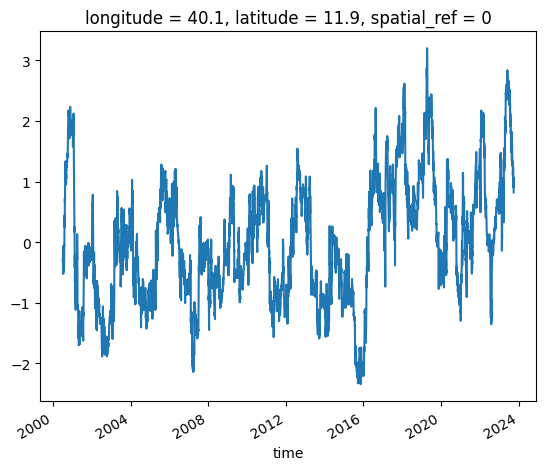

In [9]:
#%% Compute SPEI using clim
# Use xclim: https://xclim.readthedocs.io/en/stable/api.html#xclim.indicators.atmos.standardized_precipitation_evapotranspiration_index

import xclim.indices as xcl

# Compute potential evaporation: 
zdc['pev'] = zdc['pev'] * 1000
zdc['pev'].attrs['units'] = 'mm/day'

wb = zdc['precip'] - zdc['pev']
wb.attrs['units'] = 'mm/day'

# Compute SPEI
SPEI_semester = xcl.standardized_precipitation_evapotranspiration_index(wb, wb, freq='D', window=30*6, dist='gamma', method='APP')

SPEI_semester.isel(latitude=1, longitude=1).plot()

SPEI_semester.to_netcdf('SPEI_6M.nc')



In [5]:
# SPEI
SPEI = xr.open_dataset('SPEI_6M.nc')

SPEI = crop_ds(SPEI)
SPEI = SPEI.rename_vars({'__xarray_dataarray_variable__': 'SPEI_6M'})

SPEI = SPEI.SPEI_6M.interp({'longitude': era5.longitude, 'latitude': era5.latitude}, method='nearest')

# Transpose the variables
SPEI = SPEI.transpose('time', 'latitude', 'longitude')

# Get the time range of the shorter dataset
start_time = era5.time.min()
end_time = era5.time.max()

# Crop the longer dataset to match the time range of the shorter dataset
SPEI = SPEI.sel(time=slice(start_time, end_time))

output_vars['SPEI_6M'] = SPEI

output_fname = 'UC2_Climate_Cube.nc'

# Interpolate missing data
zdc = zdc.interp()
# In my PC this raises some problems, but saving as nc (to_netcat) works fine
# zdc = xr.Dataset(output_vars).to_zarr(output_fname, consolidated=True)
zdc = xr.Dataset(output_vars).to_netcdf(output_fname)


c:\Users\chema\anaconda3\envs\DC_Cubes\lib\site-packages\xarray\coding\variables.py:511: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype)
